In [7]:
import torch

class Linear:

    def __init__(self, fn_in, fn_out, bias=True, generator=None):
        self.weight = torch.randn((fn_in, fn_out), generator=generator) / fn_in**0.5
        self.bias = torch.zeros(fn_out) if bias else None
        self.gain = 5/3
       
    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


In [8]:
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):

        self.eps = eps
        self.momentum = momentum
        self.training = True
        # normalization parameters (they are trained during backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers for use after training, calculated with a 'momentum' update
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):

        if self.training:
            xmean = x.mean(0,keepdim=True) # batch mean
            xvar = x.var(0,keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar =self.running_var
        
        # normalization math
        y = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = y * self.gamma + self.beta

        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [9]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    

In [10]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
g = torch.Generator().manual_seed(2147483647)

str_data = open('shakespear.txt', 'r').read()
char_set = sorted(list(set(''.join(str_data))))
char_encode = {ch:i for i,ch in enumerate(char_set)}
char_decode = {i:ch for ch,i in char_encode.items()}
vocab_size = len(char_decode)
print("vocab size:", vocab_size)

block_size = 4
def build_dataset(str_data):
    X, Y = [], []
    context = [0] * block_size
    for ch in str_data:
        idx = char_encode[ch]
        X.append(context)
        Y.append(idx)
        context = context[1:] + [idx]
        # print(''.join(char_decode[i] for i in idx_in), '-->', char_decode[idx_out])
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8*len(str_data))
n2 = int(0.9*len(str_data))
Xtr, Ytr = build_dataset(str_data[:n1])
Xdev, Ydev = build_dataset(str_data[n1:n2])
Xte, Yte = build_dataset(str_data[n2:])


vocab size: 62
torch.Size([79994, 4]) torch.Size([79994])
torch.Size([9999, 4]) torch.Size([9999])
torch.Size([10000, 4]) torch.Size([10000])


In [11]:
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_emb),            generator=g)

layers = [
    Linear(n_emb * block_size, n_hidden),   Tanh(),
    Linear(n_hidden,n_hidden),              Tanh(),
    # Linear(n_hidden,n_hidden),              Tanh(),
    # Linear(n_hidden,n_hidden),              Tanh(),
    # Linear(n_hidden,n_hidden),              Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    # make last  layer less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= layer.gain

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

lossi = []

61482


In [24]:
max_steps = 4000

for i in range(max_steps):

    if i == 0:
        lr = 0.0001 
        batch_size = 25000
        print(f"======================\nIter: {i}\n  learning rate: {lr}\n  batch size: {batch_size}\n----------------------")
    # elif i == int(.5 * max_steps) or i == int(.95 * max_steps):
    #     lr = lr/10 # learning rate decay
    #     batch_size = batch_size*8
    #     print(f"======================\nIter: {i}\n  learning rate: {lr}\n  batch size: {batch_size}\n----------------------")
        
    #batch input and output data
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb] # embedding every element of inputs into N-D vector space
    x = emb.view(emb.shape[0],-1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    #backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    for p in parameters:
        p.data += -lr * p.grad

    if i % 100 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    # if i > 1000: break
    # break
    
    lossi.append(loss.log10().item())
print(loss.item())


Iter: 0
  learning rate: 0.0001
  batch size: 25000
----------------------
      0/   4000: 1.0909
    100/   4000: 1.0705
    200/   4000: 1.1033
    300/   4000: 1.1025
    400/   4000: 1.0942
    500/   4000: 1.0907
    600/   4000: 1.0806
    700/   4000: 1.0775
    800/   4000: 1.0972
    900/   4000: 1.0895
   1000/   4000: 1.0911
   1100/   4000: 1.0857
   1200/   4000: 1.0956
   1300/   4000: 1.0911
   1400/   4000: 1.0759
   1500/   4000: 1.1001
   1600/   4000: 1.0902
   1700/   4000: 1.0778
   1800/   4000: 1.0896
   1900/   4000: 1.0879
   2000/   4000: 1.0828
   2100/   4000: 1.1029
   2200/   4000: 1.0847
   2300/   4000: 1.0942
   2400/   4000: 1.0857
   2500/   4000: 1.0929
   2600/   4000: 1.0966
   2700/   4000: 1.0924
   2800/   4000: 1.0890
   2900/   4000: 1.0906
   3000/   4000: 1.0930
   3100/   4000: 1.0934
   3200/   4000: 1.1002
   3300/   4000: 1.1073
   3400/   4000: 1.0940
   3500/   4000: 1.0923
   3600/   4000: 1.0973
   3700/   4000: 1.0917
   3800/   40

train 1.092247486114502
dev 1.9225393533706665
test 1.9658664464950562


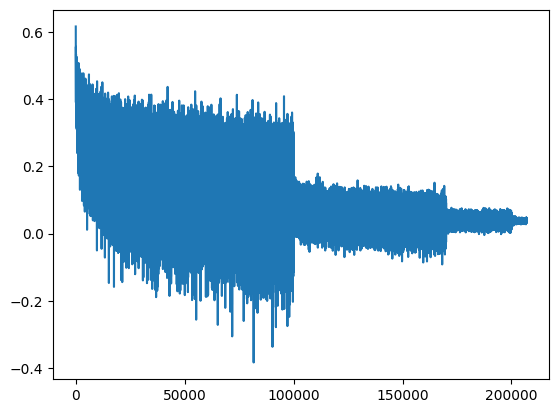

In [26]:
import matplotlib.pyplot as plt

def get_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # embedding every element of inputs into N-D vector space
    x = emb.view(emb.shape[0],-1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

get_loss('train')
get_loss('dev')
get_loss('test')

plt.plot(lossi)

layer 1 (      Tanh): mean +0.01, std: +0.93, saturated: 70.02%
layer 3 (      Tanh): mean -0.05, std: +0.93, saturated: 71.40%


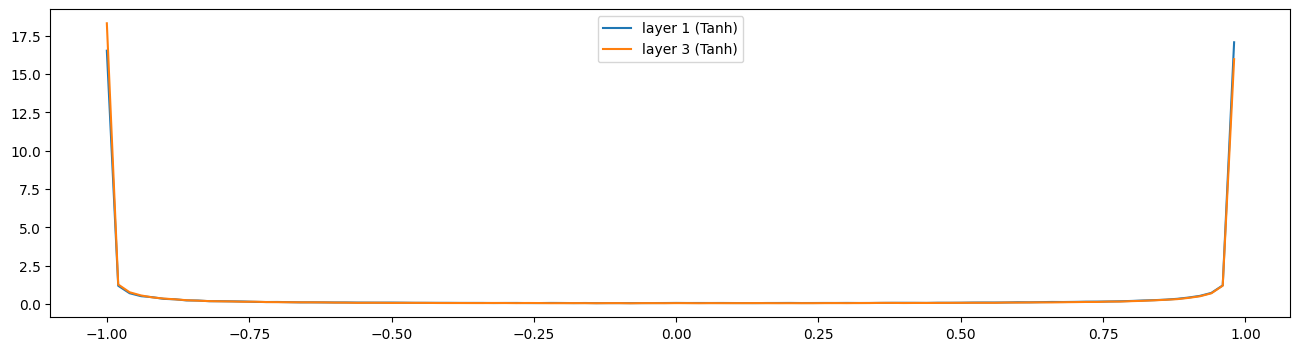

In [13]:
# Plot a histogram of the activation values of each layer (select the Tanh part of each layer)
%matplotlib inline

plt.figure(figsize=(16,4))
legend = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        mean = t.mean()
        print(f"layer {i} ({layer.__class__.__name__ :>10s}): mean {t.mean():+.2f}, std: {t.std():+.2f}, saturated: {(t.abs() > .97).float().mean()*100:.2f}%")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legend.append(f"layer {i} ({layer.__class__.__name__})")

plt.legend(legend)

layer 1 (      Tanh): mean -0.0000, std: +0.0001, saturated: 0.0000%
layer 3 (      Tanh): mean +0.0000, std: +0.0001, saturated: 0.0000%


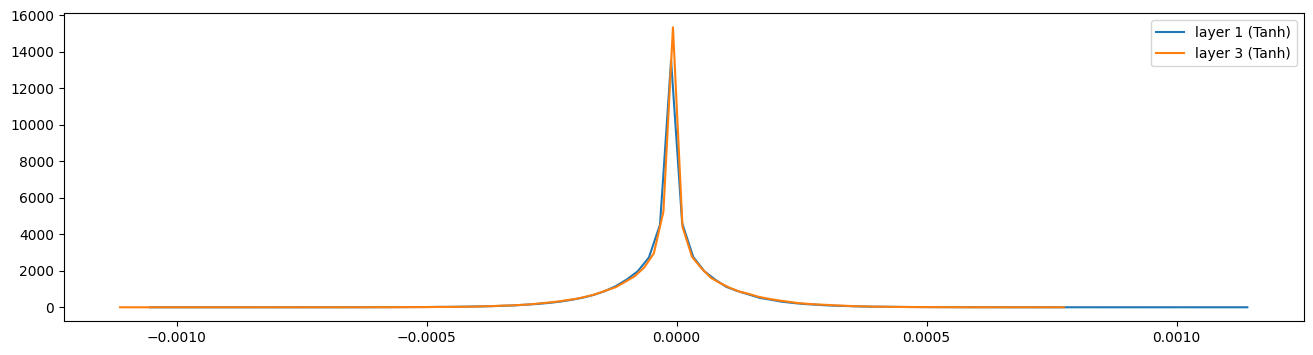

In [14]:
plt.figure(figsize=(16,4))
legend = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f"layer {i} ({layer.__class__.__name__ :>10s}): mean {t.mean():+.4f}, std: {t.std():+.4f}, saturated: {(t.abs() > .97).float().mean()*100:.4f}%")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legend.append(f"layer {i} ({layer.__class__.__name__})")

plt.legend(legend)

In [27]:
for i in range(1):
    out = []
    ix = 0
    n = 0
    context = [0] * block_size
    while n < 10000:

        x = C[torch.tensor([context])] # (1,block_size,d)
        x = x.view(1,-1)
        for layer in layers:
            x = layer(x)
        probs = F.softmax(x, dim=1)
        ix = torch.multinomial(probs, 1, replacement=True, generator=g).item()
        context = context[1:] + [ix]
        out.append(char_decode[ix])
        n += 1

    print(''.join(out))

There in my stony ambididinging made
That army your gentlemans firm were countent other; and people; he behold before day and die
SS And my was forsl soul,
Till most prove, I will stortune own of he other:
Yare her, call the Julief in his foot concluded,
And with my inking: I will nhe more up to-day, their heavens and not dieter world,
Bosts, and
Which made cas wholes have a should so my bed-es and in that's for our father
To my lord; I saw true, sit as much gallant confident!

Second Lord:
Themp as
Fing here the was side:
And say!

TROILUS:
Now Baples.

ANGELO:
When your knees. I have bles I do his wirly in there shace what I would disposity of leath!
Good, you loud for your horses tell, and her.

OJNA:
I that this safe to host;
Hence: my face
An alone and so here nephew prindeeder with a serven;
Py poeds, propose
To good I am deranch these would then bloody rame that fage, if hearant in every dismerry, but in thy brook, be gods, and in their knighty to thin my boys; and I yest out ho